# Advanced Atom Selection with SMARTS and Mapped SMILES

This notebook demonstrates the advanced atom selection capabilities in rdkit2ase, including support for mapped SMILES patterns and sophisticated hydrogen handling.

In [1]:
from rdkit.Chem import CombineMols, Draw

import rdkit2ase

## Basic Atom Selection with SMARTS

The `select_atoms_grouped` function provides advanced atom selection capabilities beyond the basic `match_substructure` function. Let's start with a simple example using ethanol.

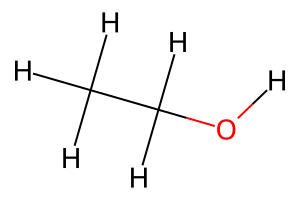

In [2]:
# Create an ethanol molecule with explicit hydrogens
ethanol_smiles = "CCO"
ethanol_mol = rdkit2ase.ase2rdkit(rdkit2ase.smiles2atoms(ethanol_smiles))

# Display the molecule
Draw.MolToImage(ethanol_mol, size=(300, 200))

In [3]:
# Select all carbon atoms using SMARTS
carbon_indices = rdkit2ase.select_atoms_grouped(ethanol_mol, "[#6]")
print(f"Carbon atom indices: {carbon_indices}")

# Select the oxygen atom
oxygen_indices = rdkit2ase.select_atoms_grouped(ethanol_mol, "[#8]")
print(f"Oxygen atom indices: {oxygen_indices}")

Carbon atom indices: [[0, 1]]
Oxygen atom indices: [[2]]


In [4]:
# if we have two molecules, they are returned as a list
# Select all carbon atoms using SMARTS. Indices are returned per molecule
carbon_indices = rdkit2ase.select_atoms_grouped(
    CombineMols(ethanol_mol, ethanol_mol), "[#6]"
)
print(f"Carbon atom indices: {carbon_indices}")

Carbon atom indices: [[0, 1], [9, 10]]


## Hydrogen Handling Options

One of the key features is sophisticated hydrogen handling with three different modes: `exclude` (default), `include`, and `isolated`.

In [5]:
# Select the C-O bond pattern with different hydrogen handling
pattern = "CO"  # Carbon-Oxygen bond

# Default: exclude hydrogens
exclude_h = rdkit2ase.select_atoms_grouped(ethanol_mol, pattern, hydrogens="exclude")
print(f"Exclude hydrogens: {exclude_h}")

# Include hydrogens attached to matched heavy atoms
include_h = rdkit2ase.select_atoms_grouped(ethanol_mol, pattern, hydrogens="include")
print(f"Include hydrogens: {include_h}")

# Return only the hydrogens attached to matched heavy atoms
isolated_h = rdkit2ase.select_atoms_grouped(ethanol_mol, pattern, hydrogens="isolated")
print(f"Isolated hydrogens: {isolated_h}")

Exclude hydrogens: [[1, 2]]
Include hydrogens: [[1, 6, 7, 2, 8]]
Isolated hydrogens: [[6, 7, 8]]


## Mapped SMILES Support and Atom Ordering

A powerful feature is support for mapped SMILES patterns, where only atoms with map numbers (e.g., [C:1]) are returned from the selection. **New in this version**: atoms are now returned in the order of their map numbers, providing predictable and controllable atom ordering.

In [6]:
# Using mapped SMILES to select only specific atoms
# This pattern matches the carbon-carbon-oxygen chain,
# but only returns the mapped carbons
mapped_pattern = "[C:1][C:2]O"
mapped_indices = rdkit2ase.select_atoms_grouped(ethanol_mol, mapped_pattern)
print(f"Mapped carbon indices: {mapped_indices}")

# Compare with unmapped pattern which returns all atoms in the match
unmapped_pattern = "CCO"
unmapped_indices = rdkit2ase.select_atoms_grouped(ethanol_mol, unmapped_pattern)
print(f"Unmapped pattern indices: {unmapped_indices}")

Mapped carbon indices: [[0, 1]]
Unmapped pattern indices: [[0, 1, 2]]


In [7]:
# Demonstrate atom ordering with mapped patterns
# Create alanine dipeptide for more complex example
aladip = rdkit2ase.smiles2atoms("CC(=O)NC(C)C(=O)NC")
aladip_mol = rdkit2ase.ase2rdkit(aladip)

# Select atoms in map order 1, 2, 3, 4
indices_1234 = rdkit2ase.select_atoms_grouped(
    aladip_mol, "CC(=O)N[C:1]([C:2])[C:3](=O)[N:4]C"
)
print(f"Map order 1,2,3,4: {indices_1234}")

# Select the same atoms but in different map order 4, 3, 2, 1
indices_4321 = rdkit2ase.select_atoms_grouped(
    aladip_mol, "CC(=O)N[C:4]([C:3])[C:2](=O)[N:1]C"
)
print(f"Map order 4,3,2,1: {indices_4321}")

Map order 1,2,3,4: [[4, 5, 6, 8]]
Map order 4,3,2,1: [[8, 6, 5, 4]]


## Visualization of Selected Atoms

The `visualize_selected_molecules` function allows you to visualize molecules with highlighted atom selections. It accepts a variable length of indices, which can be used to highlight specific atoms in the molecule.

Aromatic carbons: [[1, 2, 3, 4, 5, 6]]
Methyl carbon: [[0]]


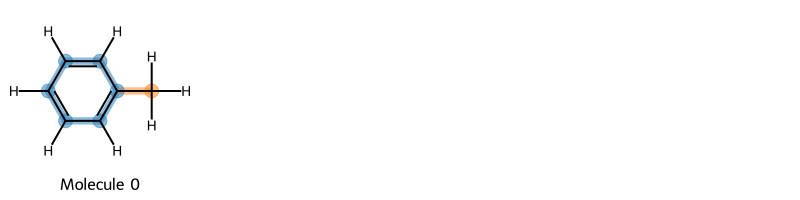

In [ ]:
toluene_smiles = "Cc1ccccc1"  # Toluene
toluene_mol = rdkit2ase.ase2rdkit(rdkit2ase.smiles2atoms(toluene_smiles))

# Select different atom types
aromatic_carbons = rdkit2ase.select_atoms_grouped(toluene_mol, "c", hydrogens="exclude")
methyl_carbon = rdkit2ase.select_atoms_grouped(
    toluene_mol, "[C;!c]", hydrogens="exclude"
)

print(f"Aromatic carbons: {aromatic_carbons}")
print(f"Methyl carbon: {methyl_carbon}")

img = rdkit2ase.visualize_selected_molecules(
    toluene_mol, aromatic_carbons[0], methyl_carbon[0]
)
img

Multi-selection visualization with custom parameters created


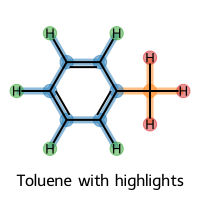

In [9]:
# Or multiple selections with custom parameters
multi_selection = rdkit2ase.visualize_selected_molecules(
    toluene_mol,
    rdkit2ase.select_atoms_grouped(toluene_mol, "c", hydrogens="exclude")[0],
    rdkit2ase.select_atoms_grouped(toluene_mol, "C", hydrogens="exclude")[0],
    rdkit2ase.select_atoms_grouped(toluene_mol, "c", hydrogens="isolated")[0],
    rdkit2ase.select_atoms_grouped(toluene_mol, "C", hydrogens="isolated")[0],
    mols_per_row=1,
    legends=["Toluene with highlights"],
)
print("Multi-selection visualization with custom parameters created")
multi_selection

## Advanced Example: Selecting Functional Groups

Let's demonstrate a more complex example with a molecule containing multiple functional groups.

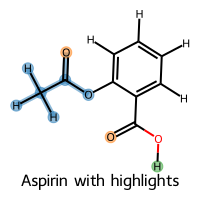

In [ ]:
aspirin_smiles = "CC(=O)Oc1ccccc1C(=O)O"  # (aspirin)
aspirin_mol = rdkit2ase.ase2rdkit(rdkit2ase.smiles2atoms(aspirin_smiles))
# Display the molecule
rdkit2ase.visualize_selected_molecules(
    aspirin_mol,
    # functional group
    rdkit2ase.select_atoms_grouped(
        aspirin_mol, "[C:1][C:2](=O)[O:4]c1ccccc1C(=O)O", hydrogens="include"
    )[0],
    # double-bonded oxygen but without the carbon
    rdkit2ase.select_atoms_grouped(aspirin_mol, "[O:1]=C")[0],
    # hydrogens of the C-O-H group
    rdkit2ase.select_atoms_grouped(aspirin_mol, "CO", hydrogens="isolated")[0],
    mols_per_row=1,
    legends=["Aspirin with highlights"],
)